**Predicting Unperformed Clininal Trial Sites - 0601 Model**

gareth@ibm.com | Gareth Cheng

### 1. Import Packages

In [1]:
import sys
import os
import math
import logging
import pandas as pd
import numpy as np
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
py.init_notebook_mode(connected=True)

import category_encoders as ce
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, matthews_corrcoef
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import xgboost as xgb

from scipy.stats import pearsonr, spearmanr, kendalltau
from tqdm import tqdm
from ast import literal_eval
from datetime import datetime
from datetime import timedelta
from random import randint

import warnings
warnings.filterwarnings('ignore')

### 2. Helper Function

In [2]:
# Helper Functions
str_fmt = {
    'int': '{:.0f}',
    'pct': '{:.2%}',
    'pct1': '{:.1%}',
    'pct4': '{:.4%}',
    'comma': '{:,.0f}',
    'decimal': '{:,.3}',
    'dollar': '${:,.2f}',
    'dollar0': '${:,.0f}'
}

def display_all(df, head=None):
    '''Display all rows and columns in Jupyter'''
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        if head:
            display(df.head(head))
        else:
            display(df)

def value_counts_pcts(series: pd.Series, dropna=True):
    '''Show element counts and percent of total for an input Series'''
    a = series.value_counts(dropna=dropna).to_frame()
    b = series.value_counts(dropna=dropna, normalize=True).to_frame()
    return a.join(b, lsuffix='_count', rsuffix='_pct')

def value_counts_pcts_df(df: pd.DataFrame):
    '''Show element counts and percent of total for an input DataFrame'''
    a = df.value_counts().rename('count').to_frame()
    b = df.value_counts(normalize=True).rename('pct').to_frame()
    return a.join(b).sort_index()

def nulls_info(data):
    '''Show element null counts and percent of total, for either an input Series or DataFrame'''
    if isinstance(data, pd.DataFrame):
        a = data.isnull().sum()[lambda x: x > 0].rename('null_count').to_frame()
        b = (data.isnull().sum()/len(data))[lambda x: x > 0].rename('pct_of_total').to_frame()
        c = data[a.index.tolist()].dtypes.astype(str).rename('col_dtype').to_frame()
    elif isinstance(data, pd.Series):
        idx = '0' if data.name == None else data.name
        a = pd.Series(data.isnull().sum(), index=[idx]).rename('null_count').to_frame()
        b = pd.Series((data.isnull().sum()/len(data)), index=[idx]).rename('pct_of_total').to_frame()
        c = pd.Series(data.dtypes, index=[idx]).astype(str).rename('col_dtype').to_frame()
    else:
        raise ValueError('Input must be either pd.DataFrame or pd.Series')
    return a.join(b).join(c).sort_values('null_count', ascending=False)

from typing import List
def ListFilter(lst: List, substr, excl=False, exact=False) -> List: 
    '''Filter a list by another list of substrings (include or exclude)'''
    if type(substr) is not list:
        substr = [substr]
    if exact:
        if excl:
            lst_out = [s for s in lst if not any(sub == s for sub in substr)]
        else:
            lst_out = [s for s in lst if any(sub == s for sub in substr)]
    else:
        if excl:
            lst_out = [s for s in lst if not any(sub in s for sub in substr)]
        else:
            lst_out = [s for s in lst if any(sub in s for sub in substr)]
    return lst_out


def corr_heatmap(corr, annot=True):
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    g = sns.heatmap(corr, mask=mask, annot=annot, fmt='.2g', cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=.5)
    return g
    
def pairplot_hue(df, xplot, yplot_hue):
    g = sns.pairplot(df[[xplot, yplot_hue]], hue=yplot_hue, size=4)
    g._legend.remove()
    plt.legend(title=yplot_hue, loc='center left', bbox_to_anchor=(1, 0.5))
    return g



### 3. Data Exploration 

In [3]:
# merged table
data = pd.read_csv('0531_merged_features.csv')

In [4]:
# shape 
data.shape

(150208, 122)

In [5]:
# 25% of the site is default, meaning they unperformed  
category_counts = data['is_default'].value_counts(normalize=True) * 100
print(category_counts)

0    75.64444
1    24.35556
Name: is_default, dtype: float64


In [6]:
# data without ii_
data = data.filter(regex=r'^(?!ii_)')

In [7]:
# data without hi_
# data = data.filter(regex=r'^(?!hi_)')

### 4. Feature Engineering

In [8]:
display_all(data.head())

,nct,golden_id,pi_golden_id,phase,country,city_country,sponsor,predicted_ta,predicted_mesh,total_site,study_open_date,protocol_complexity_score,pcs_randomization_parameter,pcs_lit_length_invest_treatment,pcs_nsa_number_arms_param,pcs_uas,pcs_icp,pcs_fpi,pcs_pfe_parameter,pcs_followup_score,site_type,is_default,site_study_end,site_study_count,site_study_ta_count,pi_study_count,pi_study_ta_count,default_site_3y,default_site_ta_3y,default_pi_3y,default_pi_ta_3y,default_site_5y,default_site_ta_5y,default_pi_5y,default_pi_ta_5y,mesh_default_mean,ta_default_mean,naive_site,naive_site_ta,naive_pi,naive_pi_ta,county,Facility Postal,state,hi_population_total,hi_population_26to64,hi_population_over64,hi_less_than_high_school_26to64,hi_high_school_26to64,hi_some_college_or_associates_26to64,hi_bachelors_and_above_26to64,hi_less_than_high_school_over64,hi_high_school_over64,hi_some_college_or_associates_over64,hi_bachelors_and_above_over64,hi_less_than_high_school_over26,hi_high_school_over26,hi_some_college_or_associates_over26,hi_bachelors_and_above_over26,hi_uninsured_over26,hi_private_insurance_over26,hi_public_insurance_over26,hi_public_26to64,hi_public_over64,hi_private_26to64,hi_private_over64,hi_uninsured_26to64,hi_uninsured_over64,num_of_investigator_per_site,num_of_patients_per_site,num_of_female_patients_per_site,num_of_child_patients_per_site,num_unique_icd10_per_site,num_unique_icd10_initials_per_site,most_freq_icd_per_site
0,NCT00019786,DD32386,NaN,II,United States,Chapel Hill_United States,Amgen,Oncology,[],19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Academic Hospital / Clinic,0,2009-04-17,22,5,20371,3997,0.263158,0.250000,NaN,NaN,0.272727,0.200000,NaN,NaN,NaN,0.271387,0,0,NaN,NaN,Orange County,27514,North Carolina,89992.0,68286.0,21706.0,3548.0,8257.0,12290.0,44191.0,1388.0,3939.0,4058.0,12321.0,4936.0,12196.0,16348.0,56512.0,7313.0,72312.0,26887.0,6244.0,20643.0,57428.0,14884.0,6855.0,458.0,270.0,203381.0,110431.0,16681.0,2220.0,22.0,C
1,NCT00019786,DD342719,NaN,II,United States,Durham_United States,Amgen,Oncology,[],19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Academic Institution - research facility,0,2007-08-14,12,9,3460,1257,0.333333,0.444444,NaN,NaN,0.333333,0.444444,NaN,NaN,NaN,0.271387,0,0,NaN,NaN,Durham County,27710,North Carolina,212045.0,168533.0,43512.0,18138.0,27637.0,35125.0,87633.0,4490.0,9847.0,10726.0,18449.0,22628.0,37484.0,45851.0,106082.0,29355.0,152870.0,59887.0,19714.0,40173.0,126118.0,26752.0,28136.0,1219.0,421.0,141528.0,71247.0,22757.0,2505.0,22.0,C
2,NCT00019786,DD4205,NaN,II,United States,Stanford_United States,Amgen,Oncology,[],19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Academic Institution - research facility,0,2009-04-22,20,8,20520,4033,0.210526,0.250000,NaN,NaN,0.210526,0.250000,NaN,NaN,NaN,0.271387,0,0,NaN,NaN,Santa Clara County,94305,California,1312930.0,1050299.0,262631.0,101497.0,137301.0,219864.0,591637.0,44478.0,42835.0,60649.0,114669.0,145975.0,180136.0,280513.0,706306.0,68442.0,1005828.0,378716.0,137802.0,240914.0,867892.0,137936.0,65421.0,3021.0,332.0,275890.0,138815.0,17442.0,3014.0,23.0,C
3,NCT00019786,DD5265,NaN,II,United States,San Antonio_United States,Amgen,Oncology,[],19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clinical Trial Center,0,2009-06-05,11,3,22072,4255,0.200000,0.500000,NaN,NaN,0.272727,0.666667,NaN,NaN,NaN,0.271387,0,0,NaN,NaN,Bexar County,78229,Texas,1237992.0,994588.0,243404.0,139981.0,255308.0,315681.0,283618.0,51907.0,61539.0,66553.0,63405.0,191888.0,316847.0,382234.0,347023.0,228311.0,803460.0,374930.0,142138.0,232792.0,677468.0,125992.0,224167.0,4144.0,142.0,1628603.0,812816.0,124155.0,2299.0,23.0,C
4,NCT00019786,DD64008,NaN,II,United States,Evanston_United States,Amgen,Oncology,[],19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non-academic Hospital / Clinic,1,2001-06-07,0,0,6,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.271387,1,1,NaN,NaN,Cook County,60202,Illinois,3463018.0,2708117.0,754901.0,284965.0,569839.0,669830.0,1183483.0,132897.0,210090.0,182878.0,229036

#### 4-1: Indication (Predicted Mesh)

In [9]:
data = data.replace('[]', np.nan)

#### 4-2: Study Duration 

In [10]:
# Convert the date columns to datetime type
data['study_open_date'] = pd.to_datetime(data['study_open_date'])
data['site_study_end'] = pd.to_datetime(data['site_study_end'])

# Calculate the duration
data['study_duration'] = (data['site_study_end'] - data['study_open_date']).dt.total_seconds()
data['study_duration'] = data['study_duration'] / 86400

#### 4-3: Mean study duration for each indication 

In [11]:
mesh_study_dur_mean = data.groupby(['predicted_mesh']).median()['study_duration'].reset_index()
mesh_study_dur_mean = mesh_study_dur_mean.rename(columns={'study_duration': 'mesh_study_duration_median'})

In [12]:
data = pd.merge(data, mesh_study_dur_mean, how="left", on=['predicted_mesh'])

### 5. Dealing with Missing Values 

In [13]:
display_all(data.head())

,nct,golden_id,pi_golden_id,phase,country,city_country,sponsor,predicted_ta,predicted_mesh,total_site,study_open_date,protocol_complexity_score,pcs_randomization_parameter,pcs_lit_length_invest_treatment,pcs_nsa_number_arms_param,pcs_uas,pcs_icp,pcs_fpi,pcs_pfe_parameter,pcs_followup_score,site_type,is_default,site_study_end,site_study_count,site_study_ta_count,pi_study_count,pi_study_ta_count,default_site_3y,default_site_ta_3y,default_pi_3y,default_pi_ta_3y,default_site_5y,default_site_ta_5y,default_pi_5y,default_pi_ta_5y,mesh_default_mean,ta_default_mean,naive_site,naive_site_ta,naive_pi,naive_pi_ta,county,Facility Postal,state,hi_population_total,hi_population_26to64,hi_population_over64,hi_less_than_high_school_26to64,hi_high_school_26to64,hi_some_college_or_associates_26to64,hi_bachelors_and_above_26to64,hi_less_than_high_school_over64,hi_high_school_over64,hi_some_college_or_associates_over64,hi_bachelors_and_above_over64,hi_less_than_high_school_over26,hi_high_school_over26,hi_some_college_or_associates_over26,hi_bachelors_and_above_over26,hi_uninsured_over26,hi_private_insurance_over26,hi_public_insurance_over26,hi_public_26to64,hi_public_over64,hi_private_26to64,hi_private_over64,hi_uninsured_26to64,hi_uninsured_over64,num_of_investigator_per_site,num_of_patients_per_site,num_of_female_patients_per_site,num_of_child_patients_per_site,num_unique_icd10_per_site,num_unique_icd10_initials_per_site,most_freq_icd_per_site,study_duration,mesh_study_duration_median
0,NCT00019786,DD32386,NaN,II,United States,Chapel Hill_United States,Amgen,Oncology,NaN,19.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Academic Hospital / Clinic,0,2009-04-17,22,5,20371,3997,0.263158,0.250000,NaN,NaN,0.272727,0.200000,NaN,NaN,NaN,0.271387,0,0,NaN,NaN,Orange County,27514,North Carolina,89992.0,68286.0,21706.0,3548.0,8257.0,12290.0,44191.0,1388.0,3939.0,4058.0,12321.0,4936.0,12196.0,16348.0,56512.0,7313.0,72312.0,26887.0,6244.0,20643.0,57428.0,14884.0,6855.0,458.0,270.0,203381.0,110431.0,16681.0,2220.0,22.0,C,NaN,NaN
1,NCT00019786,DD342719,NaN,II,United States,Durham_United States,Amgen,Oncology,NaN,19.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Academic Institution - research facility,0,2007-08-14,12,9,3460,1257,0.333333,0.444444,NaN,NaN,0.333333,0.444444,NaN,NaN,NaN,0.271387,0,0,NaN,NaN,Durham County,27710,North Carolina,212045.0,168533.0,43512.0,18138.0,27637.0,35125.0,87633.0,4490.0,9847.0,10726.0,18449.0,22628.0,37484.0,45851.0,106082.0,29355.0,152870.0,59887.0,19714.0,40173.0,126118.0,26752.0,28136.0,1219.0,421.0,141528.0,71247.0,22757.0,2505.0,22.0,C,NaN,NaN
2,NCT00019786,DD4205,NaN,II,United States,Stanford_United States,Amgen,Oncology,NaN,19.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Academic Institution - research facility,0,2009-04-22,20,8,20520,4033,0.210526,0.250000,NaN,NaN,0.210526,0.250000,NaN,NaN,NaN,0.271387,0,0,NaN,NaN,Santa Clara County,94305,California,1312930.0,1050299.0,262631.0,101497.0,137301.0,219864.0,591637.0,44478.0,42835.0,60649.0,114669.0,145975.0,180136.0,280513.0,706306.0,68442.0,1005828.0,378716.0,137802.0,240914.0,867892.0,137936.0,65421.0,3021.0,332.0,275890.0,138815.0,17442.0,3014.0,23.0,C,NaN,NaN
3,NCT00019786,DD5265,NaN,II,United States,San Antonio_United States,Amgen,Oncology,NaN,19.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clinical Trial Center,0,2009-06-05,11,3,22072,4255,0.200000,0.500000,NaN,NaN,0.272727,0.666667,NaN,NaN,NaN,0.271387,0,0,NaN,NaN,Bexar County,78229,Texas,1237992.0,994588.0,243404.0,139981.0,255308.0,315681.0,283618.0,51907.0,61539.0,66553.0,63405.0,191888.0,316847.0,382234.0,347023.0,228311.0,803460.0,374930.0,142138.0,232792.0,677468.0,125992.0,224167.0,4144.0,142.0,1628603.0,812816.0,124155.0,2299.0,23.0,C,NaN,NaN
4,NCT00019786,DD64008,NaN,II,United States,Evanston_United States,Amgen,Oncology,NaN,19.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Non-academic Hospital / Clinic,1,2001-06-07,0,0,6,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.271387,1,1,NaN,NaN,Cook County,60202,Illinois,3463018.0,2708117.0,

In [14]:
# phase, predicted_mesh, study_open_date, pcs, site_type, default_site_3y, default_site_ta_3y, default_pi_3y

In [15]:
# dataset without missing values 
data_no_nulls = data[['sponsor',
                      'predicted_ta',
                      'total_site', 
                      'site_study_count', 
                      'site_study_ta_count', 
                      'pi_study_count', 
                      'pi_study_ta_count', 
                      'ta_default_mean', 
                      'naive_site', 
                      'naive_site_ta']]

In [16]:
data_no_nulls.head()

,sponsor,predicted_ta,total_site,site_study_count,site_study_ta_count,pi_study_count,pi_study_ta_count,ta_default_mean,naive_site,naive_site_ta
0,Amgen,Oncology,19.0,22,5,20371,3997,0.271387,0,0
1,Amgen,Oncology,19.0,12,9,3460,1257,0.271387,0,0
2,Amgen,Oncology,19.0,20,8,20520,4033,0.271387,0,0
3,Amgen,Oncology,19.0,11,3,22072,4255,0.271387,0,0
4,Amgen,Oncology,19.0,0,0,6,3,0.271387,1,1


In [17]:
# check missing values for data_no_nulls
display_all(nulls_info(data))

,null_count,pct_of_total,col_dtype
default_pi_ta_3y,69715,0.464123,float64
default_pi_ta_5y,64645,0.430370,float64
default_pi_3y,59601,0.396790,float64
default_pi_5y,55493,0.369441,float64
num_of_female_patients_per_site,45652,0.303925,float64
num_of_patients_per_site,45652,0.303925,float64
num_of_investigator_per_site,45652,0.303925,float64
num_of_child_patients_per_site,45652,0.303925,float64
num_unique_icd10_per_site,45652,0.303925,float64
num_unique_icd10_initials_per_site,45652,0.303925,float64


#### 5-1 Imputation Function 

In [18]:
def missing_value_impute(data, target_column):
    
    # dataset without missing values 
    data_no_nulls = data[['sponsor',
                          'predicted_ta',
                          'total_site', 
                          'site_study_count', 
                          'site_study_ta_count', 
                          'pi_study_count', 
                          'pi_study_ta_count', 
                          'ta_default_mean', 
                          'naive_site', 
                          'naive_site_ta']]

    # one-hot encoding for entire dataset 
    categorical_cols = ['sponsor', 'predicted_ta'] 
    data_temp = pd.get_dummies(data, columns = categorical_cols, drop_first = True)

    # Split the data into non-missing and missing values
    df_missing = data_temp[data_temp[target_column].isnull()]
    df_nonmissing = data_temp[data_temp[target_column].notnull()]

    # one-hot encoding for subset without null values for training purpose 
    data_no_nulls = pd.get_dummies(data_no_nulls, columns = categorical_cols, drop_first = True)

    # Build a random forest classifier or any suitable model
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier()

    # features for training
    features = list(data_no_nulls.columns)

    # Fit the model on non-missing values
    model.fit(df_nonmissing[features], df_nonmissing[target_column])

    # Predict the missing values
    imputed_values = model.predict(df_missing[features])

    # Assign the predicted values to the missing values
    data.loc[data[target_column].isnull(), target_column] = imputed_values

In [19]:
display_all(nulls_info(data['site_type']))

,null_count,pct_of_total,col_dtype
site_type,22810,0.151856,object


In [20]:
missing_value_impute(data, 'phase')

In [21]:
# missing_value_impute(data, 'predicted_mesh')
# missing_value_impute(data, 'site_type')
# missing_value_impute(data, 'num_of_female_patients_per_site')
# missing_value_impute(data, 'default_pi_ta_3y')
# missing_value_impute(data, 'default_pi_ta_5y')
# missing_value_impute(data, 'default_pi_3y')
# missing_value_impute(data, 'default_pi_5y')
# missing_value_impute(data, 'num_of_patients_per_site')
# missing_value_impute(data, 'num_of_investigator_per_site')
# missing_value_impute(data, 'num_unique_icd10_initials_per_site')
# missing_value_impute(data, 'most_freq_icd_per_site')
# missing_value_impute(data, 'mesh_study_duration_median')
# missing_value_impute(data, 'num_unique_icd10_per_site')

### 6. Data Manipulation 

In [41]:
# excluding IDs & redundant features 
data = data.drop(['nct', 
                  'golden_id', 
                  'pi_golden_id', 
                  'country',
                  'city_country',
                  'study_open_date',
                  'site_study_end',
                  'Facility Postal',
                  'county',
                  'state',
        
                  # 40% null values
                  'default_pi_ta_3y',
                  'default_site_3y',
                  'default_pi_ta_5y',
                  'default_pi_5y',
                  'default_pi_3y',
                  
                 ], axis=1)

In [21]:
# replace all "N" values in the dataframe to null values 
data = data.replace('N', np.nan)

In [17]:
# display_all(data.dtypes)

In [18]:
# data = data.astype({'ii_population_total_race_and_hispanic_or_latino_origin_black_or_african_american_alone': float, 
#                   'ii_population_total_race_and_hispanic_or_latino_origin_american_indian_and_alaska_native_alone': float,
#                     'ii_population_total_race_and_hispanic_or_latino_origin_asian_alone': float,
#                     'ii_population_total_race_and_hispanic_or_latino_origin_native_hawaiian_and_other_pacific_islander_alone': float,
#                     'ii_population_total_race_and_hispanic_or_latino_origin_some_other_race_alone': float,
#                     'ii_population_total_race_and_hispanic_or_latino_origin_two_or_more_races': float,
#                     'ii_population_total_race_and_hispanic_or_latino_origin_hispanic_or_latino_of_any_race': float,
#                     'ii_population_total_nativity_and_us_citizenship_status_native_born': float,
#                     'ii_population_total_nativity_and_us_citizenship_status_foreign_born': float,
#                     'ii_population_total_nativity_and_us_citizenship_status_foreign_born_naturalized': float,
#                     'ii_population_total_nativity_and_us_citizenship_status_foreign_born_not_a_citizen': float,
#                 })




In [19]:
data.shape

(150208, 62)

### Feature Selection 

In [22]:
quant_other = [
    
#     'total_site',
#     'protocol_complexity_score',
#     'pcs_randomization_parameter',
#     'pcs_lit_length_invest_treatment',
#     'pcs_nsa_number_arms_param',
#     'pcs_uas',
#     'pcs_icp',
#     'pcs_fpi',
#     'pcs_pfe_parameter',
#     'pcs_followup_score',
    'is_default',
    'site_study_count',
    'site_study_ta_count',
    'pi_study_count',
    'pi_study_ta_count',
    'default_site_ta_3y',
    'default_site_5y',
    'default_site_ta_5y',
    'default_pi_5y',
#     'mesh_default_mean',
#     'ta_default_mean',
#     'naive_site',
#     'naive_site_ta',
    'naive_pi',
    'naive_pi_ta',
    
]

In [23]:
claim = [
    
    'num_of_investigator_per_site',
    'num_of_patients_per_site',
    'num_of_female_patients_per_site',
    'num_of_child_patients_per_site',
    'num_unique_icd10_per_site',
    'num_unique_icd10_initials_per_site',
    'most_freq_icd_per_site',
    
]

In [25]:
health_insurance = [
    
 'hi_population_total',
 'hi_population_26to64',
 'hi_population_over64',
 'hi_less_than_high_school_26to64',
 'hi_high_school_26to64',
 'hi_some_college_or_associates_26to64',
 'hi_bachelors_and_above_26to64',
 'hi_less_than_high_school_over64',
 'hi_high_school_over64',
 'hi_some_college_or_associates_over64',
 'hi_bachelors_and_above_over64',
 'hi_less_than_high_school_over26',
 'hi_high_school_over26',
 'hi_some_college_or_associates_over26',
 'hi_bachelors_and_above_over26',
 'hi_uninsured_over26',
 'hi_private_insurance_over26',
 'hi_public_insurance_over26',
 'hi_public_26to64',
 'hi_public_over64',
 'hi_private_26to64',
 'hi_private_over64',
 'hi_uninsured_26to64',
 'hi_uninsured_over64',   

]

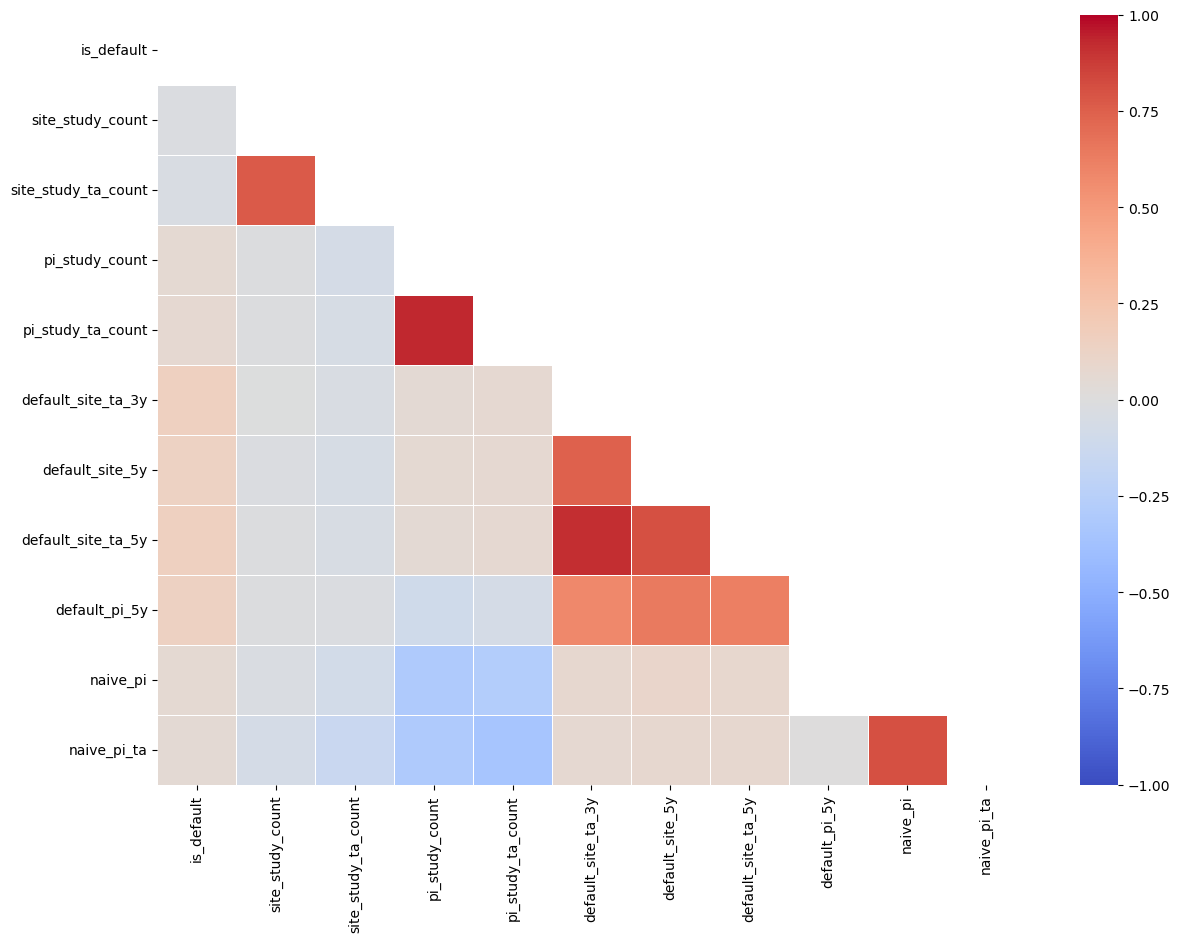

In [26]:
plt.figure(figsize=(14,10))
corr_heatmap(data[quant_other].corr(), annot=False)
plt.show()

In [40]:
# drop higly correlated columns to avoid overfitting
data = data.drop(['default_site_ta_5y', 'pi_study_count'], axis=1)

KeyError: "['default_site_ta_5y', 'pi_study_count'] not found in axis"

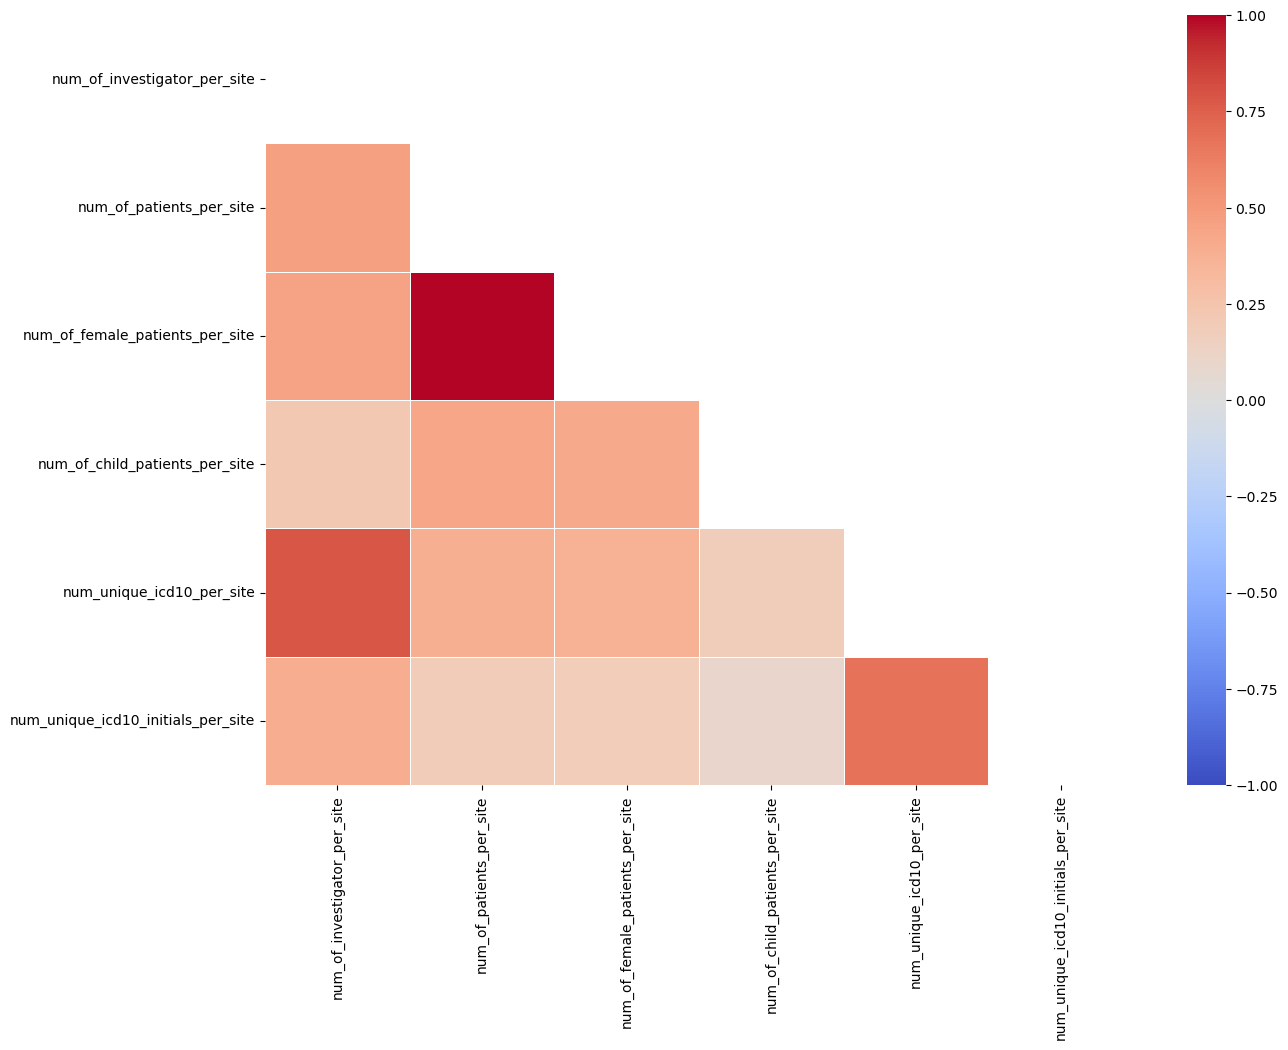

In [28]:
plt.figure(figsize=(14,10))
corr_heatmap(data[claim].corr(), annot=False) 
plt.show()

In [29]:
# drop higly correlated columns to avoid overfitting
data = data.drop(['num_of_female_patients_per_site'], axis=1)

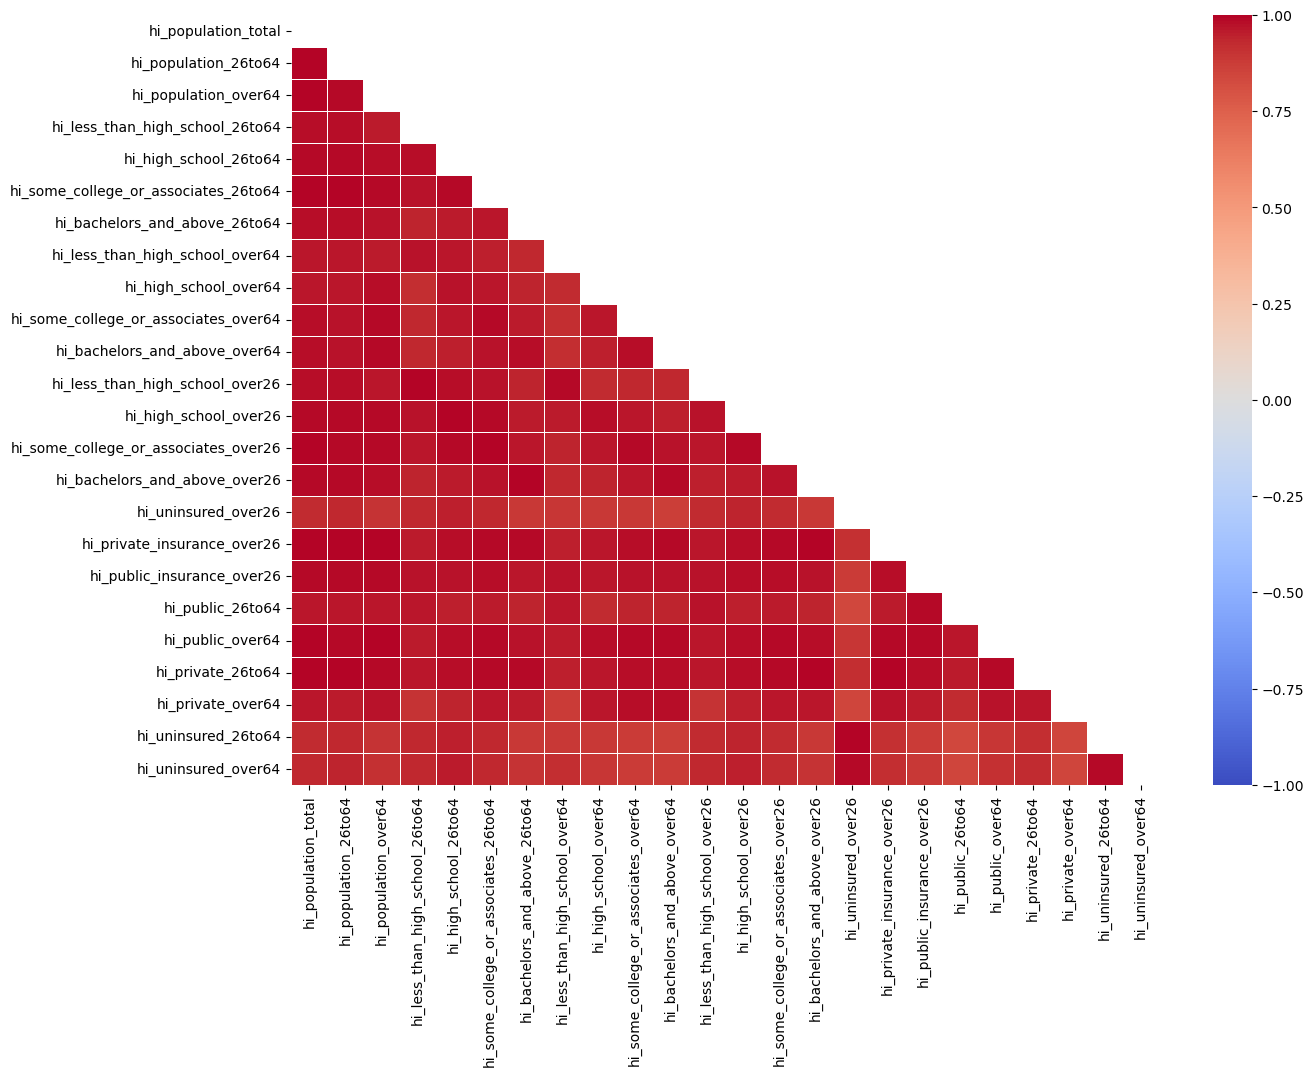

In [30]:
plt.figure(figsize=(14,10))
corr_heatmap(data[health_insurance].corr(), annot=False) 
plt.show()

In [31]:
# normalization for the health insurance dataset 
from sklearn.preprocessing import MinMaxScaler

# build the scaler model
scaler = MinMaxScaler()

# fit using the hi data
data_hi = data[health_insurance]
scaler.fit(data_hi)

# transform the test test
data_hi_scaled = scaler.transform(data_hi)

# Verify minimum value of all features
data_hi_scaled.min(axis=0)

# Verify maximum value of all features
data_hi_scaled.max(axis=0)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [33]:
data_hi_scaled

array([[0.00867016, 0.00819073, 0.01082814, ..., 0.02361097, 0.00797567,
        0.0224224 ],
       [0.02689613, 0.02703965, 0.02664529, ..., 0.045987  , 0.03677768,
        0.05967884],
       [0.19128953, 0.19283347, 0.18558496, ..., 0.25561428, 0.08723974,
        0.14789974],
       ...,
       [0.43114139, 0.41442853, 0.49579292, ..., 0.67482923, 0.44130242,
        0.3333007 ],
       [0.43114139, 0.41442853, 0.49579292, ..., 0.67482923, 0.44130242,
        0.3333007 ],
       [0.04750659, 0.04688247, 0.05021072, ..., 0.09715511, 0.01637902,
        0.01527465]])

In [36]:
data_hi_scaled = pd.DataFrame(data_hi_scaled)

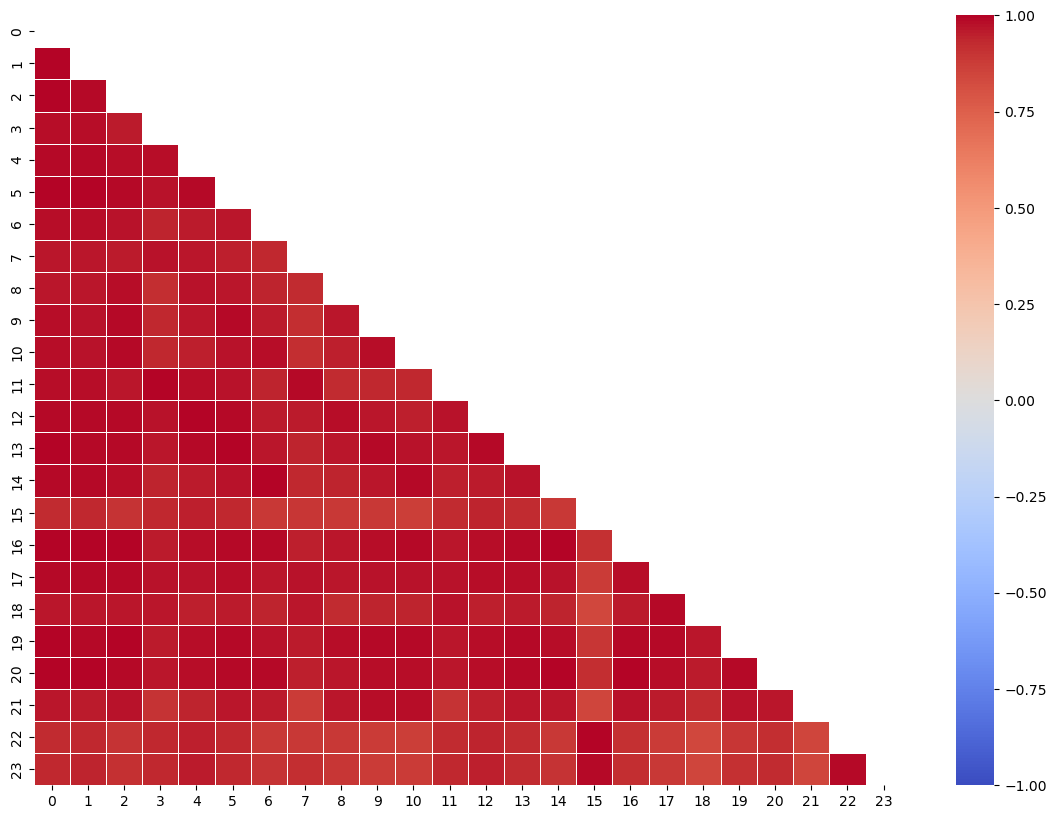

In [37]:
plt.figure(figsize=(14,10))
corr_heatmap(data_hi_scaled.corr(), annot=False) 
plt.show()

In [38]:
data = data.drop([
                  'hi_population_26to64', 
                  'hi_population_over64',  
                  'hi_public_26to64',
                  'hi_public_over64',
                  'hi_private_26to64',
                  'hi_private_over64',
                  'hi_uninsured_26to64',
                  'hi_uninsured_over64',
                  'hi_less_than_high_school_26to64',
                  'hi_high_school_26to64',
                  'hi_some_college_or_associates_26to64',
                  'hi_bachelors_and_above_26to64',
                  'hi_less_than_high_school_over64',
                  'hi_high_school_over64',
                  'hi_some_college_or_associates_over64',
                  'hi_bachelors_and_above_over64',
                  'hi_public_insurance_over26',
                  'hi_less_than_high_school_over26',
                  'hi_high_school_over26',
                  'hi_some_college_or_associates_over26',
                  'hi_bachelors_and_above_over26',
                  'hi_private_insurance_over26',
                 ], axis=1)


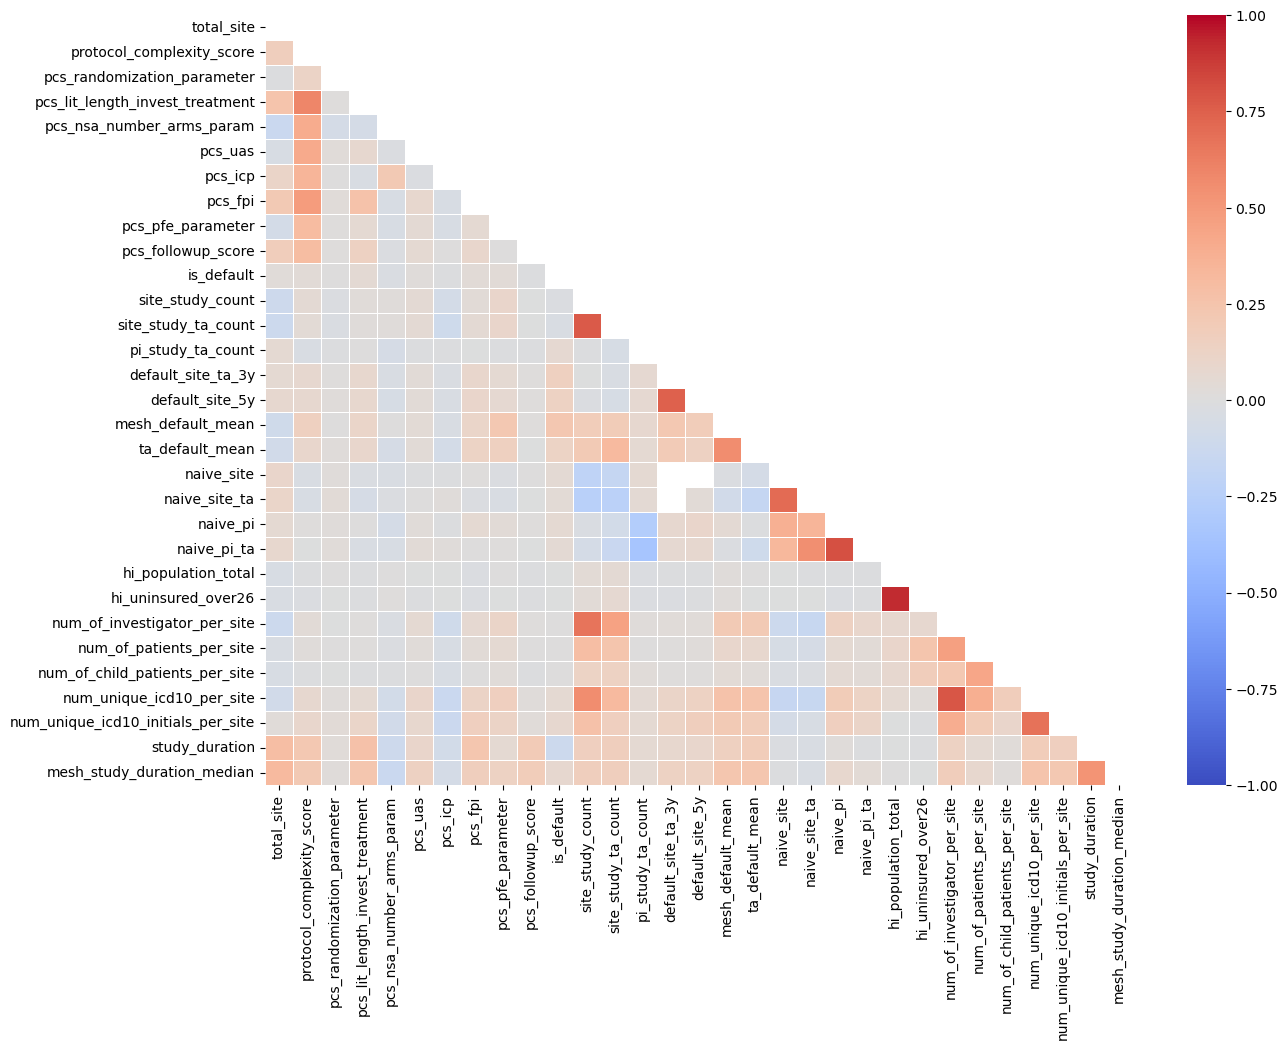

In [42]:
# overall correlation 

plt.figure(figsize=(14,10))
corr_heatmap(data.corr(), annot=False) 
plt.show()

### Encoding 

In [43]:
# binary encoding for facility city, Primary Indication, and more
categorical_cols = ['predicted_mesh'] 

# Create a BinaryEncoder instance
binary_encoder = ce.BinaryEncoder(cols=categorical_cols)

# Apply binary encoding to the DataFrame
df_encoded = binary_encoder.fit_transform(data)


In [44]:
# one hot encoding
categorical_cols = [
                    'phase', 
                    'sponsor', 
                    'predicted_ta', 
                    'site_type',
                    'most_freq_icd_per_site'
                   ] 

#import pandas as pd
df = pd.get_dummies(df_encoded, columns = categorical_cols, drop_first = True)

In [32]:
# columns_with_null = df[['num_of_investigator_per_site', 'num_of_patients_per_site', 'num_of_child_patients_per_site', 'num_unique_icd10_per_site', 'num_unique_icd10_initials_per_site']]

In [33]:
# for column in columns_with_null:
#     median_value = df[column].mean()
#     df[column].fillna(median_value, inplace=True)

### ML Pipeline 

In [48]:
# Load libraries

from pandas import set_option
# from pandas import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [45]:
columns_with_null = df.columns[df.isnull().any()]

# Impute null values with median
for column in columns_with_null:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

In [47]:
# from sklearn.preprocessing import StandardScaler
# # define standard scaler
# scaler = StandardScaler()
# # transform data
# scaled = scaler.fit_transform(df)
# print(scaled)

In [53]:
model

RandomForestClassifier()

In [54]:
model.fit(X_train, y_train)  

RandomForestClassifier()

In [67]:
# RFC model tuning 
grid_param = {
    # "n_estimators" : [90,100,115,130],
    # "criterion" : ['gini', 'entropy'],
    "max_depth" : range(2, 20, 1),
    "min_samples_leaf" : range(1, 10, 1),
    "min_samples_split" : range(2, 10, 1),
    "max_features" : ['auto', 'log2']
    
}


In [73]:
X = df.drop(['is_default'], axis=1)
y = df['is_default']

In [ ]:
from sklearn.model_selection import GridSearchCV, ParameterGrid

grid_search = GridSearchCV(model, grid_param, cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

grid_search.fit(X, y)


In [ ]:
grid_search.best_params_

In [70]:
# random seeds to be reused
random_state_sampling_seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

default = df[df['is_default'] == 1]
non_default = df[df['is_default'] == 0]

In [71]:
indexes = []
F1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
auc_scores = [] 



for i in tqdm(range(len(random_state_sampling_seeds))):
    
    # balanced data set creation
    resamp = non_default.sample(n=len(default), random_state = random_state_sampling_seeds[i] )
    indexes = indexes + resamp.index.tolist()
    balanced = pd.concat([default, resamp]).reset_index()
    

    # split train/ test
    train = balanced.drop(['is_default'], axis=1)
    target = balanced['is_default']
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=random_state_sampling_seeds[9-i])

    # create and train model
    # model = xgb.XGBClassifier(n_jobs=-1)
    model = RandomForestClassifier(n_jobs=-1, max_depth=19, max_features='auto', min_samples_leaf=1, min_samples_split=2)
    model.fit(X_train, y_train)  
    

    # prediction
    y_pred = model.predict(X_test)
    y_proba_base = model.predict_proba(X_test)

    F1_scores = F1_scores +  [metrics.f1_score(y_test , y_pred, average='binary')]
    precision_scores = precision_scores + [metrics.precision_score(y_test , y_pred, average='binary')]
    recall_scores = recall_scores + [metrics.recall_score(y_test , y_pred, average='binary')]
    accuracy_scores = accuracy_scores + [metrics.accuracy_score(y_test , y_pred)]
    auc_scores = auc_scores + [metrics.roc_auc_score(y_test , y_proba_base[:,1])]

index_arr = np.array(indexes)

100%|███████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


In [72]:
print(f"avg F1 score: {np.mean(F1_scores)}")
print(f"std of F1 score: {np.std(F1_scores)}")

print(f"avg precision score: {np.mean(precision_scores)}")
print(f"std of precision score: {np.std(precision_scores)}")

print(f"avg recall score: {np.mean(recall_scores)}")
print(f"std of recall score: {np.std(recall_scores)}")

print(f"avg accuracy score: {np.mean(accuracy_scores)}")
print(f"std of accuracy score: {np.std(accuracy_scores)}")

print(f"avg auc score: {np.mean(auc_scores)}")
print(f"std of auc score: {np.std(auc_scores)}")

avg F1 score: 0.774577626102875
std of F1 score: 0.0037581944723168704
avg precision score: 0.7855045765766164
std of precision score: 0.005227000156371494
avg recall score: 0.7639654046374875
std of recall score: 0.0036466856217319712
avg accuracy score: 0.7774224408910756
std of accuracy score: 0.003374870353801787
avg auc score: 0.8601124962696087
std of auc score: 0.0030273348747618385


In [51]:
importance_scores = model.feature_importances_

# Create a DataFrame to display the feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance_scores})

feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != 'index']

# Sort the DataFrame by importance scores in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
display_all(feature_importance_df.head(50))

,Feature,Importance
39,study_duration,0.105759
11,total_site,0.051922
26,mesh_default_mean,0.042999
23,pi_study_ta_count,0.039616
33,hi_uninsured_over26,0.039373
25,default_site_5y,0.039272
32,hi_population_total,0.039107
21,site_study_count,0.036800
22,site_study_ta_count,0.032412
37,num_unique_icd10_per_site,0.032195
